In [1]:
import os
import cv2
import numpy as np
import math
import mediapipe as mp
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import glob
import numpy as np
from tqdm.auto import tqdm
from loader.dataloader import SkeletonData


/mnt/disk1/anaconda3/envs/anhnct/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_adjacency_matrix():
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    adj = torch.zeros((21,21))
    for connection in mp_hands.HAND_CONNECTIONS:
        adj[connection[0],connection[1]] = 1
        adj[connection[1],connection[0]] = 1
    return adj 

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class GraphConvolution(nn.Module):
	def __init__(self, input_dim, output_dim, num_vetex, act=F.relu, dropout=0.5, bias=True):
		super(GraphConvolution, self).__init__()

		self.alpha = 1.

		self.act = act
		self.dropout = nn.Dropout(dropout)
		self.weight = nn.Parameter(torch.randn(input_dim, output_dim)).to(device)
		if bias:
			self.bias = nn.Parameter(torch.randn(output_dim)).to(device)
		else:
			self.bias = None

		for w in [self.weight]:
			nn.init.xavier_normal_(w)

	def normalize(self, m):
		rowsum = torch.sum(m, 0)
		r_inv = torch.pow(rowsum, -0.5)
		r_mat_inv = torch.diag(r_inv).float()

		m_norm = torch.mm(r_mat_inv, m)
		m_norm = torch.mm(m_norm, r_mat_inv)

		return m_norm

	def forward(self, adj, x):

		x = self.dropout(x)

		# K-ordered Chebyshev polynomial
		adj_norm = self.normalize(adj)
		sqr_norm = self.normalize(torch.mm(adj,adj))
		m_norm = (self.alpha*adj_norm + (1.-self.alpha)*sqr_norm).to(device)

		x_tmp = torch.einsum('abd,de->abe', x, self.weight)
		
		x_out = torch.einsum('ij,aid->ajd', m_norm, x_tmp)
		if self.bias is not None:
			x_out += self.bias

		x_out = self.act(x_out)
		
		return x_out
		
		

class StandConvolution(nn.Module):
	def __init__(self, dims, num_classes, dropout):
		super(StandConvolution, self).__init__()

		self.dropout = nn.Dropout(dropout)
		self.conv = nn.Sequential(
                        nn.Conv1d(dims[0], dims[1], kernel_size=3, stride=1,padding = 1),
                        nn.InstanceNorm1d(dims[1]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2),
                        nn.Conv1d(dims[1], dims[2], kernel_size=3, stride=1,padding = 1),
                        nn.Dropout(0.2),
                        nn.InstanceNorm1d(dims[2]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2),
                        nn.Conv1d(dims[2], dims[3], kernel_size=3, stride=1,padding = 1),
                        nn.Dropout(0.2),
                        nn.InstanceNorm1d(dims[3]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2)
                        ).to(device)
		self.fc = nn.Linear(64*21, num_classes).to(device)

	def forward(self, x):
		
		x = self.dropout(x.permute(0,2,1))
		x_tmp = self.conv(x)
		x_out = self.fc(x_tmp.view(x.size(0), -1))

		return x_out


In [4]:
class GGCN(nn.Module):
	def __init__(self, adj, num_classes, gc_dims, sc_dims, dropout=0.5):
		super(GGCN, self).__init__()

		terminal_cnt = 5
		actor_cnt = 1
		self.adj = adj + torch.eye(adj.size(0)).to(adj).detach()
	
		self.gcl = GraphConvolution(gc_dims[0], gc_dims[1], 21, dropout=dropout)
		self.conv= StandConvolution(sc_dims, num_classes, dropout=dropout)

	def forward(self, x):
		
		multi_conv = self.gcl(self.adj, x) # 1,21,3
		logit = self.conv(multi_conv)
		return logit

In [5]:
def train(train_loader,model,criterion,optimizer,device):
    running_loss = 0
    model.train()
   
    for images,labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    
    epoch_loss = running_loss / (len(train_loader))
    return model,epoch_loss,optimizer

def validate(valid_loader,model,criterion,device):
    model.eval()
    running_loss = 0
   
    
    for images,labels in tqdm(valid_loader):
       
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()

    epoch_loss = running_loss / (len(valid_loader))
    return model,epoch_loss

def get_accuracy(model,data_loader,device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = torch.argmax(torch.softmax(outputs,1),1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct*100/total

def plot_losses(train_losses,valid_losses):
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_losses, color="blue", label="train_loss")
    ax1.plot(valid_losses, color="red", label="valid_loss")
    ax1.set(title="Loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax1.legend()
    
def plot_accuracy(train_acc,valid_acc):
    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_acc, color="blue", label="train_acc")
    ax1.plot(valid_acc, color="red", label="val_acc")
    ax1.set(title="Accuracy over epochs",
            xlabel="Epoch",
            ylabel="Accuracy")
    ax1.legend()
    

In [7]:
train_set = SkeletonData("data/108_data/train.txt")
val_set = SkeletonData("data/108_data/validation.txt")
test_set = SkeletonData("data/108_data/test.txt")

train_loader = DataLoader(train_set,batch_size = 128,drop_last = False)
valid_loader = DataLoader(val_set,batch_size = 512,drop_last = False)
test_loader = DataLoader(test_set,batch_size = 512,drop_last = False)

features =  175250  class =  175250
features =  75150  class =  75150
features =  79509  class =  79509


In [41]:
from util.evaluation import early_stopping
device = 'cuda:0'
model = GGCN(find_adjacency_matrix(),19,[3,9],[9, 16, 32, 64],0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 150
train_losses = []
valid_losses = []
train_accuracy = []
val_accuracy = []
for epoch in range(epochs):
    # training
    model,train_loss,optimizer = train(train_loader,model,criterion,optimizer,device)
    
    # validation
    with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
    train_acc = get_accuracy(model,train_loader,device)
    val_acc = get_accuracy(model,valid_loader,device)
    print("Epoch {} --- Train loss = {} --- Valid loss = {} -- Train set accuracy = {} % Valid set Accuracy = {} %".format
          (epoch+1,train_loss,valid_loss,train_acc,val_acc))
    # save loss value
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #save accuracy
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    best_val_accuracy,should_stop = early_stopping(val_accuracy,10)
    
    if should_stop:
        break
    
    if best_val_accuracy == val_accuracy[-1]:
        torch.save(model.state_dict(),"best_model.pth")
        print("Save best model ","Best_accuracy = ",get_accuracy(model,test_loader,device))
       



  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 110.12it/s]

Epoch 1 --- Train loss = 4.163951635360718 --- Valid loss = 3.1362357139587402 -- Train set accuracy = 9.820485744456178 % Valid set Accuracy = 9.26517571884984 %


Save best model  Best_accuracy =  9.25925925925926


100%|██████████| 1/1 [00:00<00:00, 112.53it/s]


Epoch 2 --- Train loss = 2.9883422255516052 --- Valid loss = 2.887502670288086 -- Train set accuracy = 9.186906019007392 % Valid set Accuracy = 7.348242811501597 %


100%|██████████| 1/1 [00:00<00:00, 106.54it/s]


Epoch 3 --- Train loss = 2.829800695180893 --- Valid loss = 2.8833656311035156 -- Train set accuracy = 5.913410770855332 % Valid set Accuracy = 5.7507987220447285 %


100%|██████████| 1/1 [00:00<00:00, 109.05it/s]


Epoch 4 --- Train loss = 2.898128554224968 --- Valid loss = 2.826580762863159 -- Train set accuracy = 5.913410770855332 % Valid set Accuracy = 5.7507987220447285 %


100%|██████████| 1/1 [00:00<00:00, 104.82it/s]


Epoch 5 --- Train loss = 2.8390699326992035 --- Valid loss = 2.623171806335449 -- Train set accuracy = 11.721224920802534 % Valid set Accuracy = 12.460063897763579 %
Save best model  Best_accuracy =  11.419753086419753


100%|██████████| 1/1 [00:00<00:00, 103.50it/s]


Epoch 6 --- Train loss = 2.693316400051117 --- Valid loss = 2.4398512840270996 -- Train set accuracy = 24.81520591341077 % Valid set Accuracy = 24.920127795527158 %
Save best model  Best_accuracy =  22.22222222222222


100%|██████████| 1/1 [00:00<00:00, 127.43it/s]


Epoch 7 --- Train loss = 2.5252815186977386 --- Valid loss = 2.271191120147705 -- Train set accuracy = 27.349524815205914 % Valid set Accuracy = 26.837060702875398 %
Save best model  Best_accuracy =  26.234567901234566


100%|██████████| 1/1 [00:00<00:00, 111.36it/s]


Epoch 8 --- Train loss = 2.3487519025802612 --- Valid loss = 2.093277931213379 -- Train set accuracy = 31.25659978880676 % Valid set Accuracy = 31.629392971246006 %
Save best model  Best_accuracy =  29.320987654320987


100%|██████████| 1/1 [00:00<00:00, 96.19it/s]


Epoch 9 --- Train loss = 2.194260835647583 --- Valid loss = 1.9298694133758545 -- Train set accuracy = 37.27560718057022 % Valid set Accuracy = 36.10223642172524 %
Save best model  Best_accuracy =  37.03703703703704


100%|██████████| 1/1 [00:00<00:00, 105.34it/s]


Epoch 10 --- Train loss = 2.064139097929001 --- Valid loss = 1.786688208580017 -- Train set accuracy = 44.350580781415 % Valid set Accuracy = 42.81150159744409 %
Save best model  Best_accuracy =  45.06172839506173


100%|██████████| 1/1 [00:00<00:00, 121.32it/s]


Epoch 11 --- Train loss = 1.9256589114665985 --- Valid loss = 1.6671680212020874 -- Train set accuracy = 51.42555438225977 % Valid set Accuracy = 49.201277955271564 %
Save best model  Best_accuracy =  50.30864197530864


100%|██████████| 1/1 [00:00<00:00, 112.08it/s]


Epoch 12 --- Train loss = 1.7878874838352203 --- Valid loss = 1.5598669052124023 -- Train set accuracy = 56.916578669482575 % Valid set Accuracy = 54.95207667731629 %
Save best model  Best_accuracy =  55.24691358024691


100%|██████████| 1/1 [00:00<00:00, 95.09it/s]


Epoch 13 --- Train loss = 1.7054887562990189 --- Valid loss = 1.466396689414978 -- Train set accuracy = 60.190073917634635 % Valid set Accuracy = 56.54952076677316 %
Save best model  Best_accuracy =  60.49382716049383


100%|██████████| 1/1 [00:00<00:00, 91.75it/s]


Epoch 14 --- Train loss = 1.6090717762708664 --- Valid loss = 1.387170672416687 -- Train set accuracy = 65.36430834213306 % Valid set Accuracy = 60.70287539936102 %
Save best model  Best_accuracy =  62.34567901234568


100%|██████████| 1/1 [00:00<00:00, 121.08it/s]


Epoch 15 --- Train loss = 1.5009381771087646 --- Valid loss = 1.3117400407791138 -- Train set accuracy = 67.15945089757128 % Valid set Accuracy = 61.66134185303515 %
Save best model  Best_accuracy =  64.81481481481481


100%|██████████| 1/1 [00:00<00:00, 100.73it/s]


Epoch 16 --- Train loss = 1.4146831333637238 --- Valid loss = 1.245287537574768 -- Train set accuracy = 68.74340021119325 % Valid set Accuracy = 65.17571884984025 %
Save best model  Best_accuracy =  66.35802469135803


100%|██████████| 1/1 [00:00<00:00, 96.34it/s]


Epoch 17 --- Train loss = 1.338530570268631 --- Valid loss = 1.192482590675354 -- Train set accuracy = 70.3273495248152 % Valid set Accuracy = 65.49520766773163 %
Save best model  Best_accuracy =  68.20987654320987


100%|██████████| 1/1 [00:00<00:00, 108.30it/s]


Epoch 18 --- Train loss = 1.2822666317224503 --- Valid loss = 1.1412978172302246 -- Train set accuracy = 71.48891235480464 % Valid set Accuracy = 66.77316293929712 %
Save best model  Best_accuracy =  69.75308641975309


100%|██████████| 1/1 [00:00<00:00, 98.59it/s]


Epoch 19 --- Train loss = 1.2089572623372078 --- Valid loss = 1.1008833646774292 -- Train set accuracy = 72.54487856388596 % Valid set Accuracy = 66.77316293929712 %
Save best model  Best_accuracy =  70.37037037037037


100%|██████████| 1/1 [00:00<00:00, 103.73it/s]


Epoch 20 --- Train loss = 1.1547320112586021 --- Valid loss = 1.0738822221755981 -- Train set accuracy = 73.81203801478352 % Valid set Accuracy = 69.64856230031948 %
Save best model  Best_accuracy =  70.67901234567901


100%|██████████| 1/1 [00:00<00:00, 115.48it/s]


Epoch 21 --- Train loss = 1.1108166798949242 --- Valid loss = 1.0395058393478394 -- Train set accuracy = 74.86800422386483 % Valid set Accuracy = 69.64856230031948 %
Save best model  Best_accuracy =  70.98765432098766


100%|██████████| 1/1 [00:00<00:00, 102.81it/s]


Epoch 22 --- Train loss = 1.0657090246677399 --- Valid loss = 1.0167227983474731 -- Train set accuracy = 75.60718057022176 % Valid set Accuracy = 70.6070287539936 %
Save best model  Best_accuracy =  71.91358024691358


100%|██████████| 1/1 [00:00<00:00, 111.14it/s]


Epoch 23 --- Train loss = 1.0305301770567894 --- Valid loss = 0.9864402413368225 -- Train set accuracy = 76.55755015839493 % Valid set Accuracy = 71.56549520766774 %
Save best model  Best_accuracy =  72.22222222222223


100%|██████████| 1/1 [00:00<00:00, 99.89it/s]


Epoch 24 --- Train loss = 0.9918651282787323 --- Valid loss = 0.9711348414421082 -- Train set accuracy = 77.61351636747624 % Valid set Accuracy = 72.84345047923323 %
Save best model  Best_accuracy =  72.8395061728395


100%|██████████| 1/1 [00:00<00:00, 96.37it/s]


Epoch 25 --- Train loss = 0.9724231734871864 --- Valid loss = 0.9605641961097717 -- Train set accuracy = 78.03590285110876 % Valid set Accuracy = 74.4408945686901 %
Save best model  Best_accuracy =  73.14814814814815


100%|██████████| 1/1 [00:00<00:00, 102.36it/s]


Epoch 26 --- Train loss = 0.9420314878225327 --- Valid loss = 0.9402188062667847 -- Train set accuracy = 78.98627243928195 % Valid set Accuracy = 74.12140575079871 %


100%|██████████| 1/1 [00:00<00:00, 118.48it/s]


Epoch 27 --- Train loss = 0.9287268668413162 --- Valid loss = 0.9271185398101807 -- Train set accuracy = 79.09186906019008 % Valid set Accuracy = 74.4408945686901 %
Save best model  Best_accuracy =  74.38271604938272


100%|██████████| 1/1 [00:00<00:00, 88.28it/s]


Epoch 28 --- Train loss = 0.9107650890946388 --- Valid loss = 0.9173562526702881 -- Train set accuracy = 79.83104540654699 % Valid set Accuracy = 74.76038338658147 %
Save best model  Best_accuracy =  74.69135802469135


100%|██████████| 1/1 [00:00<00:00, 90.97it/s]


Epoch 29 --- Train loss = 0.8839189484715462 --- Valid loss = 0.914780855178833 -- Train set accuracy = 80.35902851108764 % Valid set Accuracy = 75.39936102236422 %
Save best model  Best_accuracy =  75.0


100%|██████████| 1/1 [00:00<00:00, 96.87it/s]


Epoch 30 --- Train loss = 0.8575380146503448 --- Valid loss = 0.9101200699806213 -- Train set accuracy = 80.8870116156283 % Valid set Accuracy = 74.12140575079871 %


100%|██████████| 1/1 [00:00<00:00, 98.92it/s]


Epoch 31 --- Train loss = 0.8593040853738785 --- Valid loss = 0.9083314538002014 -- Train set accuracy = 80.78141499472017 % Valid set Accuracy = 75.07987220447285 %


100%|██████████| 1/1 [00:00<00:00, 96.71it/s]


Epoch 32 --- Train loss = 0.8304526060819626 --- Valid loss = 0.8961563110351562 -- Train set accuracy = 81.09820485744456 % Valid set Accuracy = 76.03833865814697 %
Save best model  Best_accuracy =  76.85185185185185


100%|██████████| 1/1 [00:00<00:00, 117.40it/s]


Epoch 33 --- Train loss = 0.815910167992115 --- Valid loss = 0.8925885558128357 -- Train set accuracy = 81.62618796198521 % Valid set Accuracy = 75.39936102236422 %


100%|██████████| 1/1 [00:00<00:00, 117.90it/s]


Epoch 34 --- Train loss = 0.7929278984665871 --- Valid loss = 0.8894891142845154 -- Train set accuracy = 82.15417106652588 % Valid set Accuracy = 75.07987220447285 %


100%|██████████| 1/1 [00:00<00:00, 91.63it/s]


Epoch 35 --- Train loss = 0.7897203490138054 --- Valid loss = 0.8807716369628906 -- Train set accuracy = 82.36536430834214 % Valid set Accuracy = 76.6773162939297 %
Save best model  Best_accuracy =  78.70370370370371


100%|██████████| 1/1 [00:00<00:00, 118.68it/s]


Epoch 36 --- Train loss = 0.7531097680330276 --- Valid loss = 0.877748429775238 -- Train set accuracy = 82.78775079197466 % Valid set Accuracy = 76.03833865814697 %


100%|██████████| 1/1 [00:00<00:00, 117.70it/s]


Epoch 37 --- Train loss = 0.775190457701683 --- Valid loss = 0.8712812662124634 -- Train set accuracy = 83.10454065469905 % Valid set Accuracy = 76.35782747603834 %


100%|██████████| 1/1 [00:00<00:00, 101.47it/s]


Epoch 38 --- Train loss = 0.778583824634552 --- Valid loss = 0.8718967437744141 -- Train set accuracy = 83.10454065469905 % Valid set Accuracy = 76.99680511182109 %
Save best model  Best_accuracy =  79.62962962962963


100%|██████████| 1/1 [00:00<00:00, 96.71it/s]


Epoch 39 --- Train loss = 0.7401501834392548 --- Valid loss = 0.87175452709198 -- Train set accuracy = 83.52692713833157 % Valid set Accuracy = 76.6773162939297 %


100%|██████████| 1/1 [00:00<00:00, 111.83it/s]


Epoch 40 --- Train loss = 0.7411772534251213 --- Valid loss = 0.8681530356407166 -- Train set accuracy = 83.73812038014783 % Valid set Accuracy = 74.76038338658147 %


100%|██████████| 1/1 [00:00<00:00, 115.27it/s]


Epoch 41 --- Train loss = 0.7280882522463799 --- Valid loss = 0.8597672581672668 -- Train set accuracy = 83.9493136219641 % Valid set Accuracy = 76.6773162939297 %


100%|██████████| 1/1 [00:00<00:00, 86.69it/s]


Epoch 42 --- Train loss = 0.7152261361479759 --- Valid loss = 0.8562883138656616 -- Train set accuracy = 84.26610348468849 % Valid set Accuracy = 77.31629392971246 %
Save best model  Best_accuracy =  79.32098765432099


100%|██████████| 1/1 [00:00<00:00, 106.17it/s]


Epoch 43 --- Train loss = 0.7250380851328373 --- Valid loss = 0.860831081867218 -- Train set accuracy = 83.31573389651531 % Valid set Accuracy = 77.63578274760384 %
Save best model  Best_accuracy =  78.39506172839506


100%|██████████| 1/1 [00:00<00:00, 106.37it/s]


Epoch 44 --- Train loss = 0.7137299180030823 --- Valid loss = 0.868606686592102 -- Train set accuracy = 84.05491024287223 % Valid set Accuracy = 77.63578274760384 %
Save best model  Best_accuracy =  78.70370370370371


100%|██████████| 1/1 [00:00<00:00, 105.85it/s]


Epoch 45 --- Train loss = 0.7029489427804947 --- Valid loss = 0.858597993850708 -- Train set accuracy = 84.26610348468849 % Valid set Accuracy = 77.95527156549521 %
Save best model  Best_accuracy =  79.32098765432099


100%|██████████| 1/1 [00:00<00:00, 101.17it/s]


Epoch 46 --- Train loss = 0.6936793103814125 --- Valid loss = 0.8578153848648071 -- Train set accuracy = 84.47729672650475 % Valid set Accuracy = 77.95527156549521 %
Save best model  Best_accuracy =  79.32098765432099


100%|██████████| 1/1 [00:00<00:00, 101.68it/s]


Epoch 47 --- Train loss = 0.675829965621233 --- Valid loss = 0.8578362464904785 -- Train set accuracy = 84.47729672650475 % Valid set Accuracy = 78.27476038338658 %
Save best model  Best_accuracy =  80.24691358024691


100%|██████████| 1/1 [00:00<00:00, 109.22it/s]


Epoch 48 --- Train loss = 0.6754651293158531 --- Valid loss = 0.8593695163726807 -- Train set accuracy = 84.89968321013727 % Valid set Accuracy = 78.59424920127796 %
Save best model  Best_accuracy =  79.62962962962963


100%|██████████| 1/1 [00:00<00:00, 102.46it/s]


Epoch 49 --- Train loss = 0.666159313172102 --- Valid loss = 0.8552807569503784 -- Train set accuracy = 84.58289334741288 % Valid set Accuracy = 77.63578274760384 %


100%|██████████| 1/1 [00:00<00:00, 117.13it/s]


Epoch 50 --- Train loss = 0.661676686257124 --- Valid loss = 0.846963107585907 -- Train set accuracy = 84.58289334741288 % Valid set Accuracy = 78.59424920127796 %
Save best model  Best_accuracy =  80.55555555555556


100%|██████████| 1/1 [00:00<00:00, 98.96it/s]


Epoch 51 --- Train loss = 0.6481203138828278 --- Valid loss = 0.8539946675300598 -- Train set accuracy = 84.89968321013727 % Valid set Accuracy = 77.95527156549521 %


100%|██████████| 1/1 [00:00<00:00, 116.46it/s]


Epoch 52 --- Train loss = 0.6390745863318443 --- Valid loss = 0.8426069021224976 -- Train set accuracy = 85.53326293558607 % Valid set Accuracy = 78.27476038338658 %


100%|██████████| 1/1 [00:00<00:00, 99.77it/s]


Epoch 53 --- Train loss = 0.6109976842999458 --- Valid loss = 0.8495355844497681 -- Train set accuracy = 85.3220696937698 % Valid set Accuracy = 77.31629392971246 %


100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


Epoch 54 --- Train loss = 0.6443590484559536 --- Valid loss = 0.8534184098243713 -- Train set accuracy = 85.53326293558607 % Valid set Accuracy = 78.27476038338658 %


100%|██████████| 1/1 [00:00<00:00, 118.05it/s]


Epoch 55 --- Train loss = 0.6275270096957684 --- Valid loss = 0.8569624423980713 -- Train set accuracy = 85.53326293558607 % Valid set Accuracy = 77.31629392971246 %


100%|██████████| 1/1 [00:00<00:00, 60.89it/s]


Epoch 56 --- Train loss = 0.605946522206068 --- Valid loss = 0.8466159105300903 -- Train set accuracy = 86.48363252375924 % Valid set Accuracy = 78.27476038338658 %


100%|██████████| 1/1 [00:00<00:00, 103.76it/s]


Epoch 57 --- Train loss = 0.6317344643175602 --- Valid loss = 0.8510242700576782 -- Train set accuracy = 86.27243928194298 % Valid set Accuracy = 78.27476038338658 %


100%|██████████| 1/1 [00:00<00:00, 106.83it/s]

Epoch 58 --- Train loss = 0.6075404025614262 --- Valid loss = 0.8418982625007629 -- Train set accuracy = 86.37803590285111 % Valid set Accuracy = 78.59424920127796 %


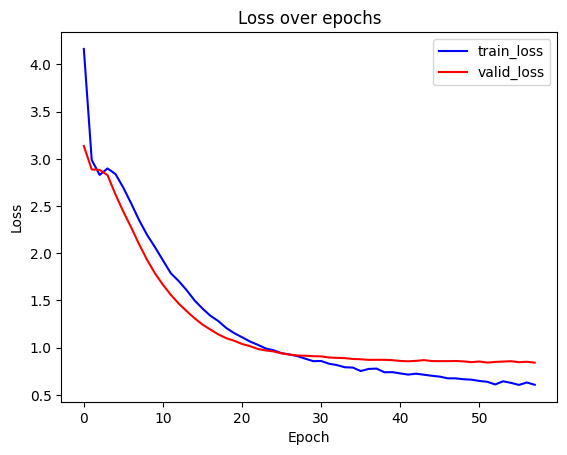

In [42]:
plot_losses(train_losses,valid_losses)

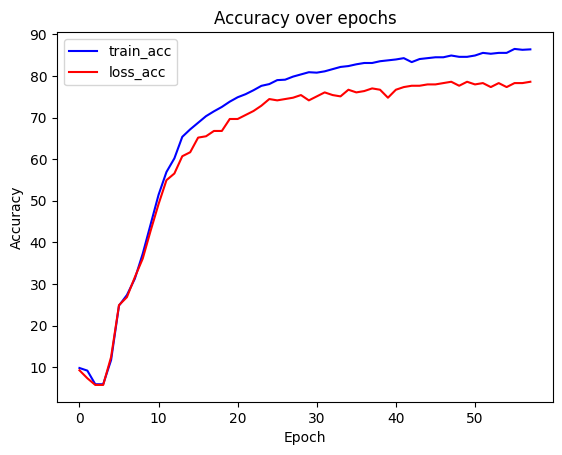

In [43]:
plot_accuracy(train_accuracy,val_accuracy)

In [44]:
get_accuracy(model,test_loader,device)

80.24691358024691